# Heart Failure Prediction Notebook
#### Author: Sam Borovoy

## TOC
- [Imports & Load Data](#1-imports--load-data)
- [Inspect Data](#2-inspect-and-clean-data)
- [EDA](#3-exploratory-analysis)
- [Data Preprocessing and Feature Scaling](#4-data-preprocessing-and-feature-scaling)
- [Model Building](##5-model-building)
    - [SVM](##i-svm)
    - [XGBoost](##ii-xgboost)
    - [KNN](##iii-knn)
- [Summary](#summary)

# 1. Imports & Load Data

In [198]:
# imports

import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, make_scorer
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier, plot_tree, plot_importance
import graphviz


In [77]:
# load in data
df = pd.read_csv("/Users/sborovoy/ml_projects/heart_failure/heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### About the data
* age: Age of the patient
* anaemia: Haemoglobin level of patient (Boolean)
* creatinine_phosphokinase: Level of the CPK enzyme in the blood (mcg/L)
* diabetes: If the patient has diabetes (Boolean)
* ejection_fraction: Percentage of blood leaving the heart at each contraction
* high_blood_pressure: If the patient has hypertension (Boolean)
* platelets: Platelet count of blood (kiloplatelets/mL)
* serum_creatinine: Level of serum creatinine in the blood (mg/dL)
* serum_sodium: Level of serum sodium in the blood (mEq/L)
* sex: Sex of the patient
* smoking: If the patient smokes or not (Boolean)
* time: Follow-up period (days)
* DEATH_EVENT: If the patient deceased during the follow-up period (Boolean)

[Attributes having Boolean values: 0 = Negative (No); 1 = Positive (Yes)]

# 2. Inspect and Clean Data

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


#### The data seems to be cleaned! All rows are non-null and dtypes look right!

# 3. Exploratory Analysis

### Heatmap

<Axes: >

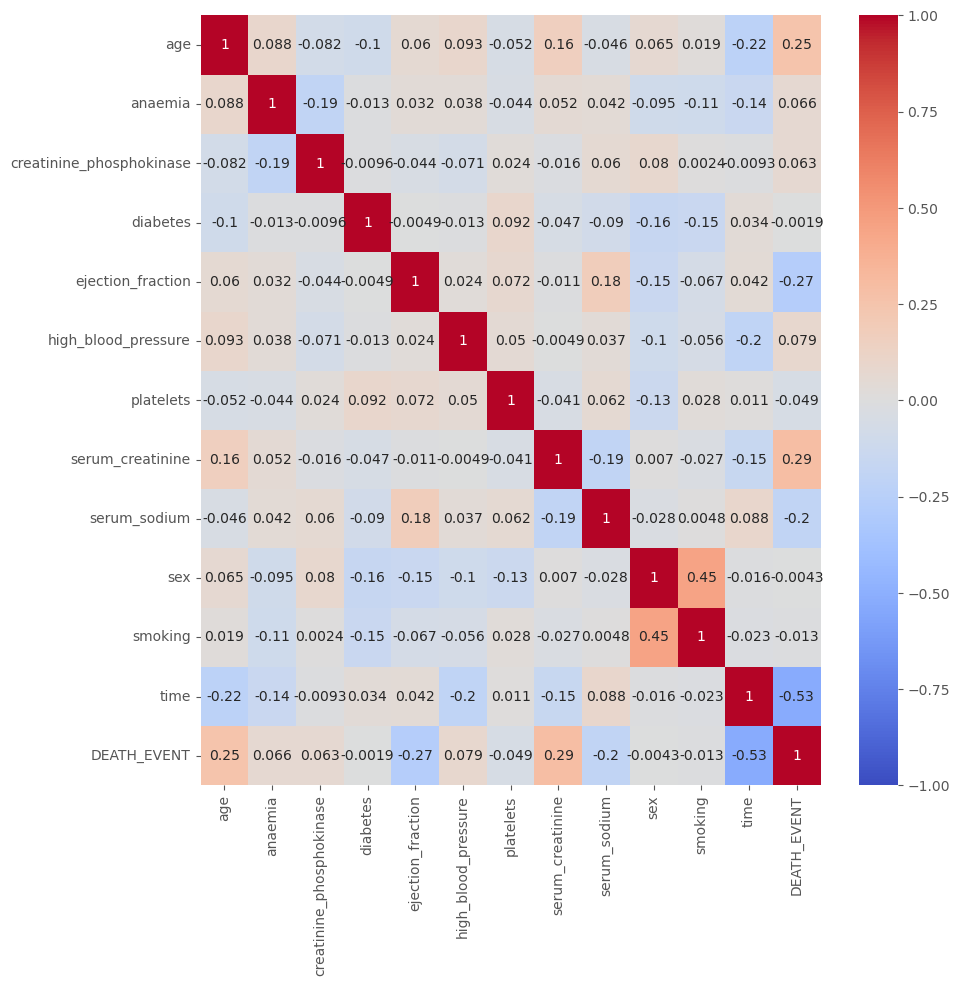

In [79]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), vmin=-1, cmap='coolwarm', annot=True)

* Age and serum_creatinine noticeably correlate positively with a death\
* Time, serum_sodium, and ejection_fraction noticeably correlate against a death.

### Smoking and Sex Breakdown

In [80]:
smokers_df = df[df['smoking']==1]
smokers_df['sex'].value_counts()

print(f"{92/96*100:.2f}% of smokers in this dataset are male.")

95.83% of smokers in this dataset are male.


### Death Event Breakdown

[Text(0, 0, '203'), Text(0, 0, '96')]

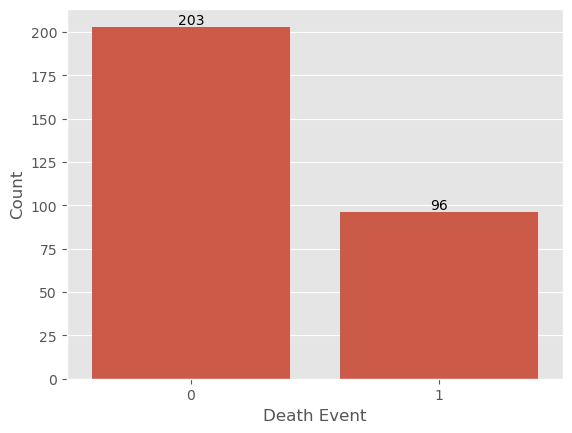

In [81]:
ax = sns.countplot(x=df["DEATH_EVENT"])
ax.set_xlabel("Death Event")
ax.set_ylabel("Count")
ax.bar_label(ax.containers[0])

### Distribution of Data

In [82]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


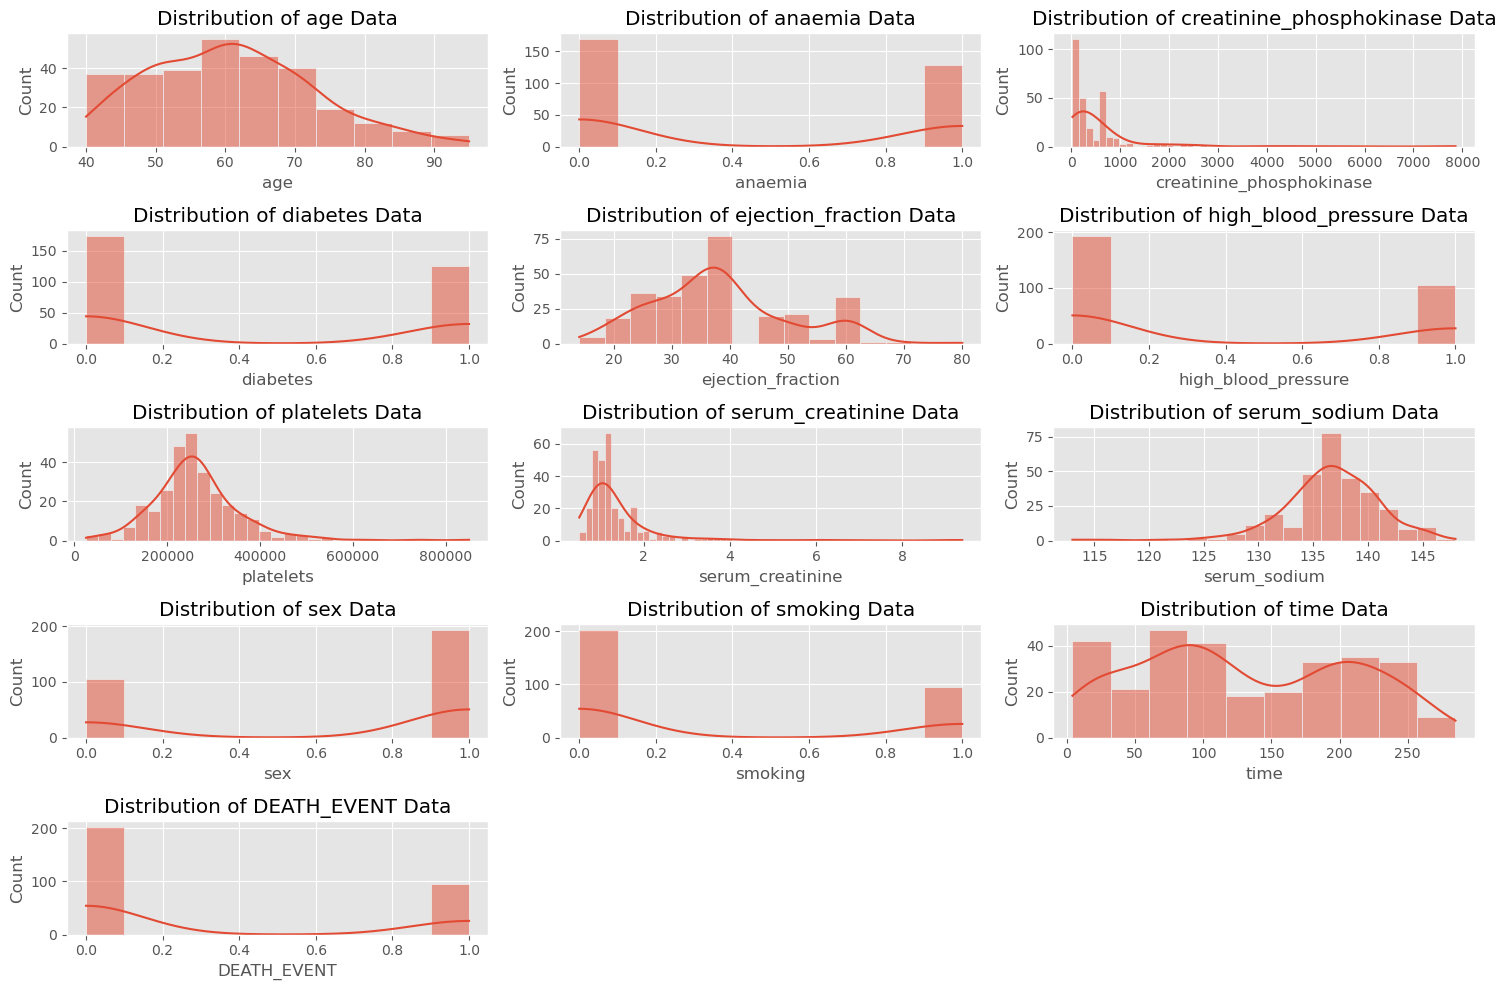

In [83]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(5,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

#### Note: Serum Creatinine and Creatinine Phosphokinase have significantly skewed distributions

### Outliers

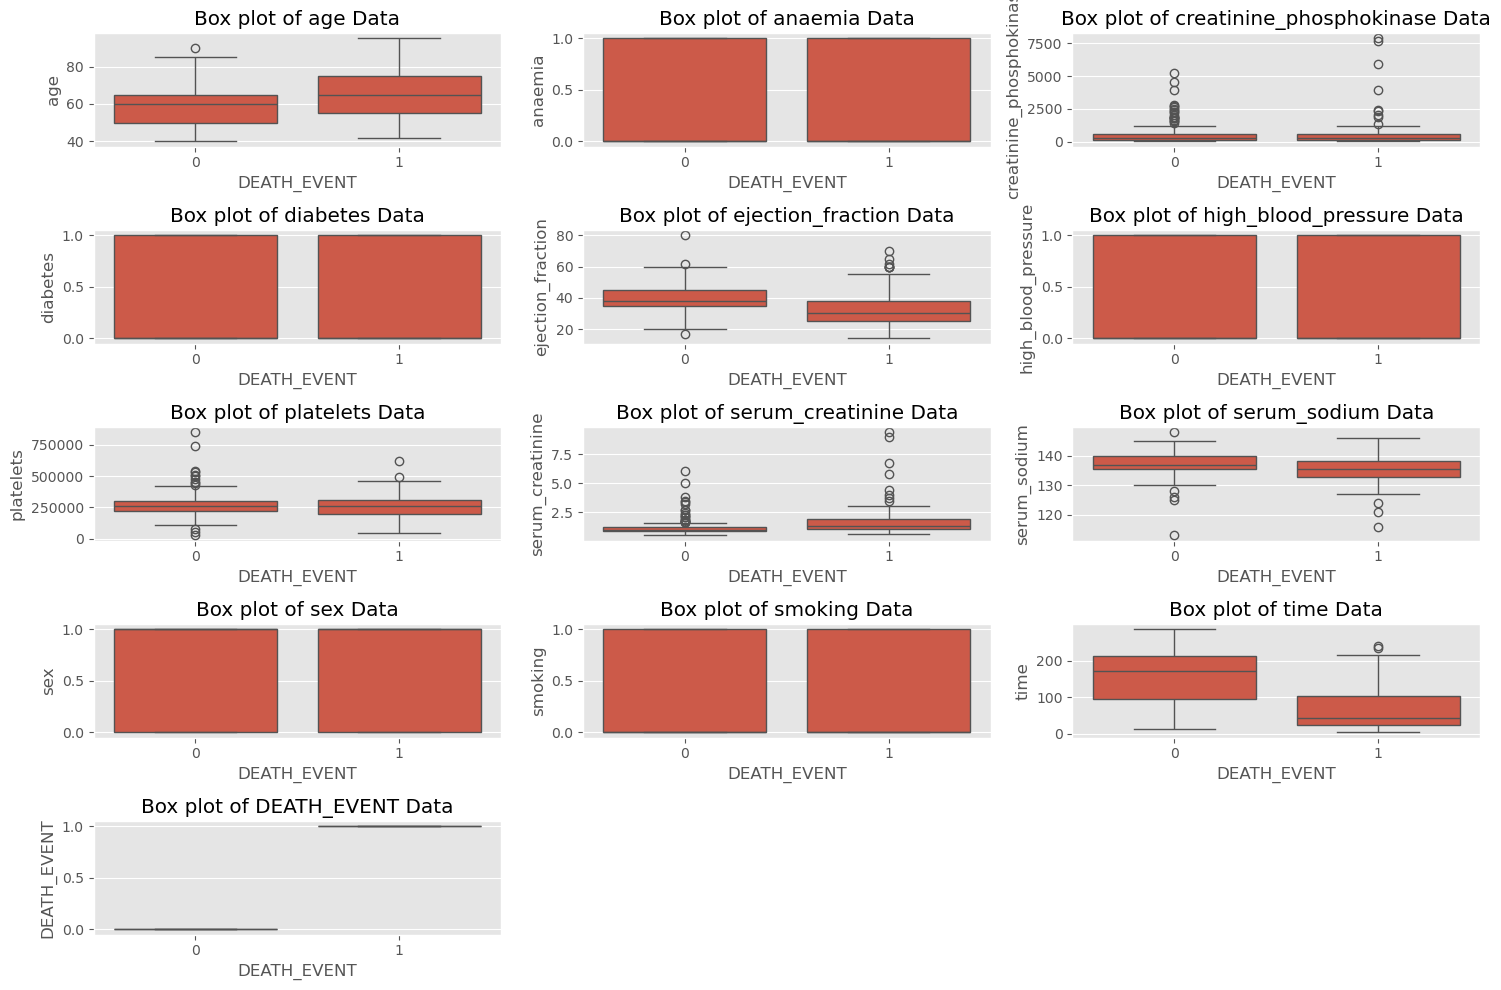

In [84]:
plt.figure(figsize=(15,10))
for i, col in enumerate(df.columns, 1):
    plt.subplot(5, 3, i)
    plt.title(f"Box plot of {col} Data")
    sns.boxplot(x='DEATH_EVENT', y=col, data=df)
    plt.tight_layout()
plt.show()

We see many outliers in the skewed features. It will be important to standardize/normalize these features before training.

### Age and Death Relationship

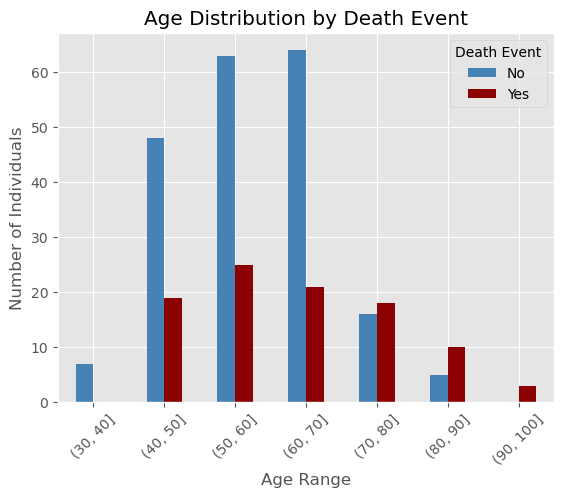

In [85]:
bins = [30, 40, 50, 60, 70, 80, 90, 100]
df['age_bins'] = pd.cut(df['age'], bins=bins)

# Group by age bins and death_event and count the occurrences
age_death_counts = df.groupby(['age_bins', 'DEATH_EVENT']).size().unstack()

# Plotting the histogram with two bars for each age range
age_death_counts.plot(kind='bar', stacked=False, color=['steelblue', 'darkred'])

plt.title('Age Distribution by Death Event')
plt.xlabel('Age Range')
plt.ylabel('Number of Individuals')
plt.xticks(rotation=45)
plt.legend(title='Death Event', labels=['No', 'Yes'])
plt.show()

There is a higher share of deaths per age range as the age range increases.

# 4. Data Preprocessing and Feature Scaling

The dataset comes with our categorical variables encoded, so no encoding is necessary.

As seen above, some of our features do not have gaussian distributions and contain outliers. Due to this, we will implement a robust scaler instead of standard scaler as it uses the median and the IQR for scaling. It subtracts the median from the data and then scales it according to the IQR.

In [86]:
# drop the age_bins column since it contains non-numeric data
df = df.drop(columns="age_bins")
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [87]:
# Robust Scaler
r_scaler = preprocessing.RobustScaler()

# Fit and transform the data
robust_scaled_data = r_scaler.fit_transform(df)
robust_df = pd.DataFrame(robust_scaled_data, columns=df.columns)

# Result
robust_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,0.043889,0.626043,-1.052632,-0.473684,0.0,0.526316,1.842105
anaemia,299.0,0.431438,0.496107,0.000000,0.000000,0.0,1.000000,1.000000
creatinine_phosphokinase,299.0,0.712867,2.084399,-0.487648,-0.286788,0.0,0.713212,16.350161
diabetes,299.0,0.418060,0.494067,0.000000,0.000000,0.0,1.000000,1.000000
ejection_fraction,299.0,0.005574,0.788989,-1.600000,-0.533333,0.0,0.466667,2.800000
high_blood_pressure,299.0,0.351171,0.478136,0.000000,0.000000,0.0,1.000000,1.000000
platelets,299.0,0.014923,1.074772,-2.603297,-0.543956,0.0,0.456044,6.461538
serum_creatinine,299.0,0.587759,2.069020,-1.200000,-0.400000,0.0,0.600000,16.600000
serum_sodium,299.0,-0.062430,0.735413,-4.000000,-0.500000,0.0,0.500000,1.833333
sex,299.0,-0.351171,0.478136,-1.000000,-1.000000,0.0,0.000000,0.000000


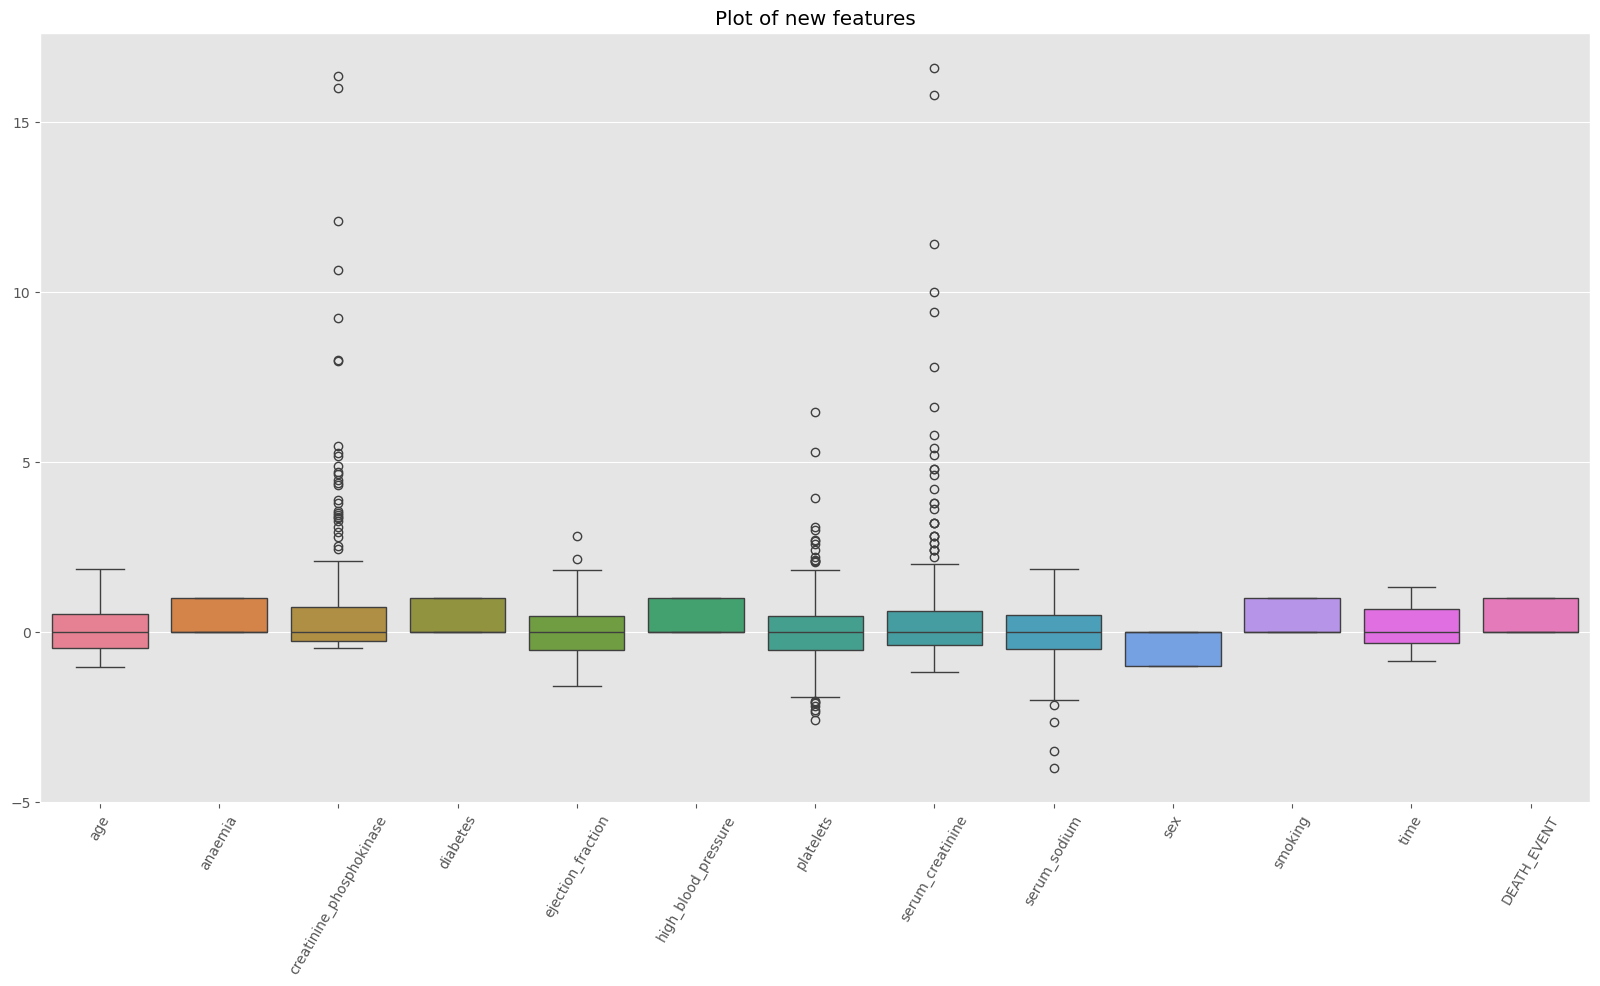

In [88]:
# visualize our new features
plt.figure(figsize=(20,10))
sns.boxplot(data = robust_df)
plt.xticks(rotation=60)
plt.title("Plot of new features")
plt.show()

In [139]:
#spliting variables into training and test sets
y = robust_df['DEATH_EVENT']
X = robust_df.drop('DEATH_EVENT', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

# 5. Model Building

## i. SVM

In [140]:
# Instantiating the SVM algorithm
svm_model=svm.SVC()

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

# Getting the score 
svm_acc = svm_model.score(X_test, y_test)
print("Accuracy of the Support Vector Machine is: ", "{:.2f}%".format(100* svm_acc))

Accuracy of the Support Vector Machine is:  88.33%


#### Evaluate the SVM model performance

In [141]:
# Printing classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92        46
         1.0       0.77      0.71      0.74        14

    accuracy                           0.88        60
   macro avg       0.84      0.82      0.83        60
weighted avg       0.88      0.88      0.88        60



In [142]:
scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

Cross-validation scores: [0.73333333 0.76666667 0.86666667 0.83333333 0.71186441]
Average cross-validation score: 0.7823728813559322


The CV accuracy is lower than the the accuracy of the predictions, a 5% average drop. This could be because of many reasons:
* overfitting in the model
* the data is not shuffled well during splitting
* the test set is unreperesentative


In [143]:
train_accuracy = svm_model.score(X_train, y_train)
test_accuracy = svm_model.score(X_test, y_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.8410041841004184
Test Accuracy: 0.8833333333333333


Since the test accuracy is higher than the train accuracy, this suggests that the splitting of the data during training or the test set is unrepresentative.\
The model could also be unstable, so switching to an ensemble method could help stabilize performance.

## ii. XGBoost

In [180]:
# resplit the original data that is not normalized for our tree-based model. Normalization can sometimes harm performance of tree based models.
y_df = df['DEATH_EVENT']
X_df = df.drop('DEATH_EVENT', axis=1)

X_train_val_df, X_test_df, y_train_val_df, y_test_df = train_test_split(
    X_df, y_df, test_size=0.2, random_state=7
)

# Further split training+validation set into training and cross-validation sets
X_train_df, X_cv_df, y_train_df, y_cv_df = train_test_split(
    X_train_val_df, y_train_val_df, test_size=0.2, random_state=7
)

In [145]:
param_grid = {
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss'],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

In [150]:
model = XGBClassifier()

# StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [151]:
# find optimal model
grid_search.fit(X_train_df, y_train_df)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'eval_metric': ['logloss'],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [2, 3, 5, 7],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 200, 500],
                         'objective': ['binary:logistic'],
                         'subsample': [0.8, 1.0]},
             scoring='f1', verbose=1)

In [153]:
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'colsample_bytree': 1.0, 'eval_metric': 'logloss', 'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'subsample': 0.8}


In [181]:
# tune the hyperparameters
model = XGBClassifier(learning_rate = 0.1, max_depth=3, min_child_weight=5, objective='binary:logistic', subsample = 0.8, colsample_bytree=0.8)
best_xgb_model = model.fit(X_train_df, y_train_df)

#### Model Evaluation:

In [182]:
# Evaluate the best model on the cross-validation set
y_cv_pred = best_xgb_model.predict(X_cv_df)
cv_accuracy = accuracy_score(y_cv_df, y_cv_pred)
print("Cross-Validation Accuracy:", cv_accuracy)

# Evaluate the best model on the test set
y_test_pred = best_xgb_model.predict(X_test_df)
test_accuracy = accuracy_score(y_test_df, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Compute and print additional metrics
train_accuracy = best_xgb_model.score(X_train_df, y_train_df)
print(f"Train Accuracy: {train_accuracy}")

# Cross-validation scores
scores = cross_val_score(best_xgb_model, X_df, y_df, cv=skf, scoring='accuracy')
print("Cross-validation accuracy scores:", scores)
print("Average cross-validation accuracy score:", scores.mean())

# F1 scores with cross-validation
f1_scorer = make_scorer(f1_score, average='weighted')
scores_f1 = cross_val_score(best_xgb_model, X_df, y_df, cv=skf, scoring=f1_scorer)
print("Cross-validation F1 scores:", scores_f1)
print("Average F1 score:", scores_f1.mean())

Cross-Validation Accuracy: 0.875
Test Accuracy: 0.9
Train Accuracy: 0.8900523560209425
Cross-validation accuracy scores: [0.85       0.9        0.86666667 0.83333333 0.88135593]
Average cross-validation accuracy score: 0.866271186440678
Cross-validation F1 scores: [0.8508799  0.9        0.8619243  0.82740538 0.87841536]
Average F1 score: 0.863724988581442


In [163]:
# examine how different random splits affect the accuracy of the model

acc = []
for i in range(1, 500):
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df,y_df,test_size=0.2,random_state=i)
    # Make predictions
    y_pred = best_xgb_model.predict(X_test_df)

    # Evaluate the model
    best_xgb_model_acc = accuracy_score(y_test_df, y_pred)
    acc.append(best_xgb_model_acc)
    
print(f"mean: {np.mean(acc)*100:.2f}%")
print(f"min: {np.min(acc)*100:.2f}%")
print(f"max: {np.max(acc)*100:.2f}%")
print(f"median: {np.mean(acc)*100:.2f}%")

mean: 90.71%
min: 80.00%
max: 100.00%
median: 90.71%


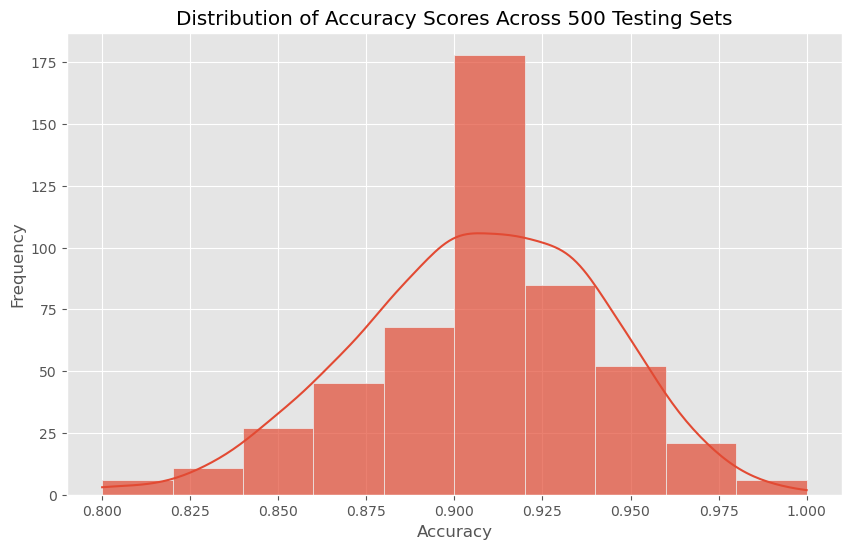

In [164]:
plt.figure(figsize=(10, 6))
sns.histplot(acc, bins=10, kde=True, alpha=0.7)
plt.title('Distribution of Accuracy Scores Across 500 Testing Sets')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

We see a rough gaussian distribution for the accuracy score on 500 unique testing sets, with most being at around 90%.

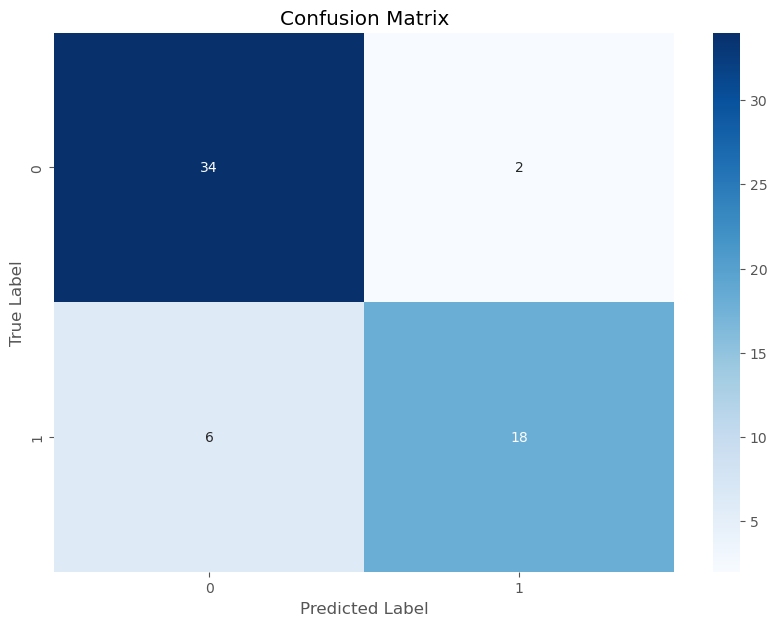

In [165]:
# confusion matrix

cm = confusion_matrix(y_test_df, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<Figure size 1000x800 with 0 Axes>

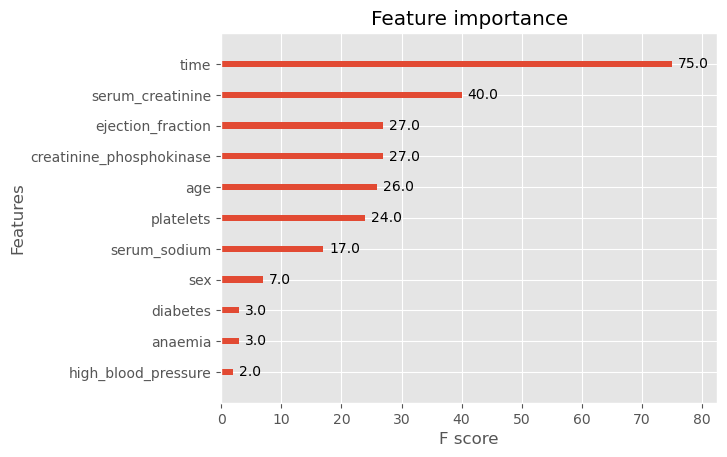

In [166]:
# most important features in the model
plt.figure(figsize=(10, 8))
plot_importance(best_xgb_model)
plt.show()

# iii. KNN

In [167]:
from sklearn.neighbors import KNeighborsClassifier

In [194]:
# X, y are robustly scaled dfs
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=7)

# Further split training+validation set into training and cross-validation sets. 20% of the dataset is for CV.
X_train, X_cv, y_train, y_cv = train_test_split(
    X_train_val, y_train_val, test_size=0.235, random_state=7)

In [195]:
# Hyperparameter tuning

# The sqrt of the sample is ~17, hence our range will be around the value.
# doing odds neighbors only to avoid ties in the voting proccess
for neighbors in range(5, 26, 2):
    kn_clf = KNeighborsClassifier(n_neighbors=neighbors)
    kn_clf.fit(X_train, y_train)
    kn_pred = kn_clf.predict(X_cv)
    
    # Calculate accuracy
    kn_acc = accuracy_score(y_cv, kn_pred)
    
    # Calculate F1 score
    kn_f1 = f1_score(y_cv, kn_pred, average='weighted')  # Use 'weighted' to account for imbalanced classes
    
    print(f"Neighbors: {neighbors} | Accuracy: {kn_acc:.3f} | F1 Score: {kn_f1:.3f}")


Neighbors: 5 | Accuracy: 0.783 | F1 Score: 0.772
Neighbors: 7 | Accuracy: 0.733 | F1 Score: 0.707
Neighbors: 9 | Accuracy: 0.700 | F1 Score: 0.680
Neighbors: 11 | Accuracy: 0.733 | F1 Score: 0.716
Neighbors: 13 | Accuracy: 0.767 | F1 Score: 0.751
Neighbors: 15 | Accuracy: 0.800 | F1 Score: 0.792
Neighbors: 17 | Accuracy: 0.783 | F1 Score: 0.777
Neighbors: 19 | Accuracy: 0.800 | F1 Score: 0.792
Neighbors: 21 | Accuracy: 0.817 | F1 Score: 0.807
Neighbors: 23 | Accuracy: 0.783 | F1 Score: 0.772
Neighbors: 25 | Accuracy: 0.783 | F1 Score: 0.772


#### The highest accuracy and f1 score is **21 neighbors**.

In [196]:
# train the KNN
kn_clf = KNeighborsClassifier(n_neighbors=21)
kn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=21)

In [197]:
# Evaluate the best model on the cross-validation set
y_cv_pred = kn_clf.predict(X_cv)
cv_accuracy = accuracy_score(y_cv, y_cv_pred)
print("Cross-Validation Accuracy:", cv_accuracy)

# Evaluate the best model on the test set
y_test_pred = kn_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Compute and print additional metrics
train_accuracy = kn_clf.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy}")

# Cross-validation scores
scores = cross_val_score(kn_clf, X, y, cv=skf, scoring='accuracy')
print("Cross-validation accuracy scores:", scores)
print("Average cross-validation accuracy score:", scores.mean())

# F1 scores with cross-validation
f1_scorer = make_scorer(f1_score, average='weighted')
scores_f1 = cross_val_score(kn_clf, X, y, cv=skf, scoring=f1_scorer)
print("Cross-validation F1 scores:", scores_f1)
print("Average F1 score:", scores_f1.mean())

Cross-Validation Accuracy: 0.8166666666666667
Test Accuracy: 0.8666666666666667
Train Accuracy: 0.7010309278350515
Cross-validation accuracy scores: [0.75       0.78333333 0.71666667 0.68333333 0.76271186]
Average cross-validation accuracy score: 0.7392090395480226
Cross-validation F1 scores: [0.70728793 0.76739157 0.67570689 0.63755476 0.73352166]
Average F1 score: 0.7042925612166494


The model is clearly unstable due to the accuracy of the model varying so much based on the testing.

# Summary

1. The XGBoost model yielded the best results with testing accuracy of 90%. The SVM and KNN were less stable and had lower accuracy values in the low 80s%.


2. I faced limitations with the dataset being small. This led to issues of generalizability and high variance in the
accuracy of the model depending on the samples in the testing set.


3. A boosting model makes sense due its ensemble learning leading to improved stability.

